<a href="https://colab.research.google.com/github/shw9807/shw9807blog/blob/master/%EC%8B%9D%EC%88%98%EC%9D%B8%EC%9B%90%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "[Colab] 식수인원 예측"

- toc:true
- branch: master
- badges: true
- author: shw9807
- categories: [데이콘]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas numpy seaborn matplotlib pycaret opencv-python

     |████████████████████████████████| 301 kB 3.2 MB/s 
     |████████████████████████████████| 2.0 MB 51.5 MB/s 
     |████████████████████████████████| 6.8 MB 47.0 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 261 kB 41.3 MB/s 
     |████████████████████████████████| 15.6 MB 33.3 MB/s 
     |████████████████████████████████| 1.7 MB 35.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 271 kB 61.0 MB/s 
     |████████████████████████████████| 1.3 MB 52.5 MB/s 
     |████████████████████████████████| 114 kB 51.4 MB/s 
     |████████████████████████████████| 167 kB 41.7 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 10.9 MB 43.7 MB/s 
     |████████████████████████████████| 303 kB 47.9 MB/s 
     |████████████████

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder


import warnings 
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
path='/content/drive/MyDrive/Colab Notebooks/식수인원예측/'

In [ ]:
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

## 날짜 데이터 전처리

In [ ]:
def process_date(df):
    df['일자'] = pd.to_datetime(df['일자'], format="%Y-%m-%d")
    df['년'] = df['일자'].dt.year
    df['월'] = df['일자'].dt.month
    df['일'] = df['일자'].dt.day
    #df = df.drop('일자', axis=1)
    return df

In [ ]:
# General preprocessing
train = process_date(train)
day_encoder = LabelEncoder()
train['요일'] = day_encoder.fit_transform(train['요일'])

test = process_date(test)
day_encoder = LabelEncoder()
test['요일'] = day_encoder.fit_transform(test['요일'])

fit_transform을 사용하면 코드가 더 간단해지지만 원래는 fit을 해준 후에 transform을 진행해야 train과 test가 같은 값으로 인코딩 된다고 한다.

In [ ]:
train['요일'].head()

0    3
1    4
2    2
3    1
4    0
Name: 요일, dtype: int64

In [ ]:
test['요일'].head()

0    2
1    1
2    0
3    3
4    4
Name: 요일, dtype: int64

train이 월 화 수 목 금  
test가 수 목 금 월 화 순서였는데 인코딩은 동일하게 된 것으로 보인다.

## 식사 가능자

In [ ]:
train['식사가능자'] = train['본사정원수'] - train['본사휴가자수'] - train['본사출장자수'] - train['현본사소속재택근무자수']

## 이전 주 식계

In [ ]:
from datetime import timedelta
train['전주중식계'] = 0
train['전주석식계'] = 0
idx = pd.DatetimeIndex(train['일자']) + timedelta(weeks=-1)
for i in range(len(train)):
    try:
        train['전주중식계'][i] = train[train['일자'] == str(idx[i])[:10]]['중식계']
        train['전주석식계'][i] = train[train['일자'] == str(idx[i])[:10]]['석식계']
    except:
        train['전주중식계'][i] = train.iloc[i,:]['중식계']
        train['전주석식계'][i] = train.iloc[i,:]['석식계']

train[['중식계', '전주중식계', '석식계', '전주석식계', '일자']].head(10)

,중식계,전주중식계,석식계,전주석식계,일자
0,1039.0,NaN,331.0,NaN,2016-02-01
1,867.0,NaN,560.0,NaN,2016-02-02
2,1017.0,NaN,573.0,NaN,2016-02-03
3,978.0,NaN,525.0,NaN,2016-02-04
4,925.0,NaN,330.0,NaN,2016-02-05
5,1045.0,978.0,550.0,525.0,2016-02-11
6,909.0,925.0,598.0,330.0,2016-02-12
7,1268.0,NaN,672.0,NaN,2016-02-15
8,1014.0,NaN,523.0,NaN,2016-02-16
9,916.0,NaN,588.0,NaN,2016-02-17


## 요일 평균 식계

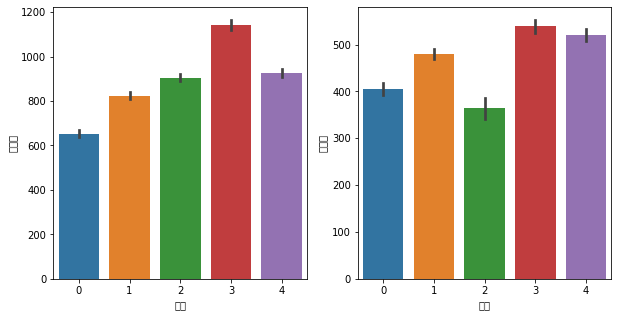

In [ ]:
# 중식계와 석식계의 요일별 시각화
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x='요일', y='중식계', data=train, ax=ax[0])
sns.barplot(x='요일', y='석식계', data=train, ax=ax[1])

순서대로 금-목-수-월-화

In [ ]:
train['요일평균중식계'] = 0
tmp = train.groupby('요일').mean()['중식계'].values
for i in range(len(tmp)):
    train['요일평균중식계'][train['요일'] == i] = tmp[i]

In [ ]:
train['요일평균석식계'] = 0
tmp = train.groupby('요일').mean()['석식계'].values
for i in range(len(tmp)):
    train['요일평균석식계'][train['요일'] == i] = tmp[i]

## 월 평균 식계

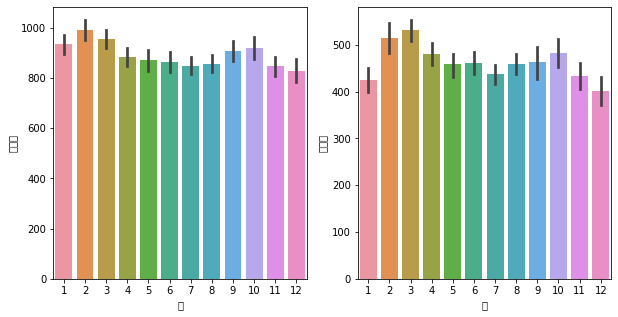

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x='월', y='중식계', data=train, ax=ax[0])
sns.barplot(x='월', y='석식계', data=train, ax=ax[1])

In [ ]:
train['월평균중식계'] = 0
tmp = train.groupby('월').mean()['중식계']
tmp_k = tmp.keys(); tmp_v = tmp.values 
for i in tmp_k:
    train['월평균중식계'][train['월'] == i] = tmp_v[i-1]

In [ ]:
train['월평균석식계'] = 0
tmp = train.groupby('월').mean()['석식계']
tmp_k = tmp.keys(); tmp_v = tmp.values
for i in tmp_k:
    train['월평균석식계'][train['월'] == i] = tmp_v[i-1]

## 공휴일 전후

In [ ]:
#공휴일 지정 노가다
train['공휴일전후'] = 0

train['공휴일전후'][17] = 1
train['공휴일전후'][3] = 1
train['공휴일전후'][62] = 1
# train['공휴일전후'][67] = 1
# train['공휴일전후'][82] = 1
train['공휴일전후'][131] = 1
# train['공휴일전후'][130] = 1
train['공휴일전후'][152] = 1
train['공휴일전후'][226] = 1
train['공휴일전후'][221] = 1
train['공휴일전후'][224] = 1
# train['공휴일전후'][244] = 1
train['공휴일전후'][245] = 1
# train['공휴일전후'][267] = 1
train['공휴일전후'][310] = 1
train['공휴일전후'][311] = 1
train['공휴일전후'][309] = 1
train['공휴일전후'][330] = 1
train['공휴일전후'][379] = 1
train['공휴일전후'][467] = 1
# train['공휴일전후'][469] = 1
train['공휴일전후'][470] = 1
train['공휴일전후'][502] = 1
# train['공휴일전후'][501] = 1
# train['공휴일전후'][511] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][623] = 1
train['공휴일전후'][651] = 1
# train['공휴일전후'][650] = 1
train['공휴일전후'][705] = 1
# train['공휴일전후'][707] = 1
train['공휴일전후'][709] = 1
# train['공휴일전후'][733] = 1
# train['공휴일전후'][748] = 1
# train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][864] = 1
# train['공휴일전후'][863] = 1
train['공휴일전후'][950] = 1
train['공휴일전후'][951] = 1
train['공휴일전후'][953] = 1
train['공휴일전후'][954] = 1
train['공휴일전후'][955] = 1
train['공휴일전후'][971] = 1
# train['공휴일전후'][970] = 1
# train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1099] = 1
train['공휴일전후'][1129] = 1
# train['공휴일전후'][1128] = 1
train['공휴일전후'][1187] = 1
# train['공휴일전후'][1186] = 1

## 자기계발의 날

In [ ]:
train['자기계발의날'] = 0
train['자기계발의날'].loc[(train['석식계'] == 0) & (train['공휴일전후'] == 0) & (train['요일'] == 2)] = 1

석식이 없고, 공휴일 전휴가 아닌 수요일을 자기계발의 날로 설정

## 테스트 데이터 전처리

### 식사가능자

In [ ]:
test['식사가능자'] = test['본사정원수'] - test['본사휴가자수'] - test['본사출장자수'] - test['현본사소속재택근무자수']

### 요일평균/ 월평균 식계

In [ ]:
def make_dow_avg(df_test, df_prev):
    dow_avg_ln = df_prev.groupby('요일').mean()['중식계']
    dow_avg_dn = df_prev.groupby('요일').mean()['석식계']
    
    df_test['요일평균중식계'] = 0
    tmp = dow_avg_ln.values
    for i in range(len(tmp)):
        df_test['요일평균중식계'][df_test['요일'] == i] = tmp[i]
        
    df_test['요일평균석식계'] = 0
    tmp = dow_avg_dn.values
    for i in range(len(tmp)):
        df_test['요일평균석식계'][df_test['요일'] == i] = tmp[i]
    
    return df_test

def make_month_avg(df_test, df_prev):
    month_avg_ln = df_prev.groupby('월').mean()['중식계']
    month_avg_dn = df_prev.groupby('월').mean()['석식계']
    
    df_test['월평균중식계'] = 0
    tmp = month_avg_ln
    tmp_k = tmp.keys(); tmp_v = tmp.values
    for i in tmp_k:
        df_test['월평균중식계'][df_test['월'] == i] = tmp_v[i-1]
        
    df_test['월평균석식계'] = 0
    tmp = month_avg_dn
    tmp_k = tmp.keys(); tmp_v = tmp.values
    for i in tmp_k:
        df_test['월평균석식계'][df_test['월'] == i] = tmp_v[i-1]
        
    return df_test

### 공휴일 전후

In [ ]:
test['공휴일전후'] = 0
test['공휴일전후'][10] =1
test['공휴일전후'][20] = 1

In [ ]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '년', '월', '일',
       '식사가능자', '전주중식계', '전주석식계', '요일평균중식계', '요일평균석식계', '월평균중식계', '월평균석식계',
       '공휴일전후', '자기계발의날'],
      dtype='object')

In [ ]:
test.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '년', '월', '일', '식사가능자', '공휴일전후'],
      dtype='object')

## 모델

### 첫 주 예측

In [ ]:
submission_df = pd.read_csv(path+'sample_submission.csv')

In [ ]:
res = []
X_test = test[['요일', '본사시간외근무명령서승인건수', '공휴일전후', '월', '일자', '일', '년',
                '본사휴가자수', '본사출장자수', '식사가능자']][:5]

In [ ]:
from datetime import timedelta
X_test = make_dow_avg(X_test, train)
X_test = make_month_avg(X_test, train)
X_test['전주중식계'] = 0
X_test['전주석식계'] = 0
index = pd.DatetimeIndex(X_test['일자']) + timedelta(weeks=-1)
for i in range(5):
    X_test['전주중식계'][i] = train[train['일자'] == str(index[i])[:10]]['중식계']
    X_test['전주석식계'][i] = train[train['일자'] == str(index[i])[:10]]['석식계']

### 첫 주 중식계

In [ ]:
from pycaret.regression import *

In [ ]:
X_train_ln = train[['요일', '본사시간외근무명령서승인건수', '전주중식계', '요일평균중식계', '월평균중식계', '공휴일전후',
                '본사휴가자수', '본사출장자수', '식사가능자', '중식계']]

In [ ]:
reg = setup(session_id=1,
            data=X_train_ln,
            target='중식계',
            #numeric_imputation = 'mean',
            normalize = True,
            #categorical_features=['월', '요일', '공휴일전후'],
            silent=True)

,Description,Value
0,session_id,1
1,Target,중식계
2,Original Data,"(1205, 10)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 13)"


regression example 모델 생성, 추후에 필요한 모든 환경을 initialize

In [ ]:
gbr_l = tune_model(create_model('gbr', criterion='mae'), optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,88.0361,13281.0895,115.2436,0.7322,0.1487,0.1080
1,77.5321,11508.5195,107.2778,0.6667,0.1162,0.0850
2,66.4988,7948.7003,89.1555,0.8111,0.1101,0.0821
3,58.9143,6671.9290,81.6819,0.8588,0.1073,0.0775
4,59.4015,5754.7130,75.8598,0.8542,0.0857,0.0667
5,65.1363,8964.1559,94.6792,0.8017,0.1220,0.0806
6,80.2396,12571.9561,112.1247,0.7166,0.1264,0.0920
7,68.3173,6871.6142,82.8952,0.7904,0.0964,0.0786
8,74.3584,9514.7625,97.5436,0.8046,0.1092,0.0861
9,72.6869,9897.9667,99.4885,0.8170,0.1430,0.0969


Gradient Boosting Regressor.
기본적으로 fold = 10 이므로 10번 반복하며 모델을 tuning

In [ ]:
pred_holdouts = predict_model(gbr_l)
final_model_l = finalize_model(gbr_l)
final_model_l

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,68.1824,8365.509,91.4632,0.8065,0.1156,0.0851


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.05, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=260,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

predict 에서는 데이터를 나누지 않고 마지막으로 데이터 전체를 학습

In [ ]:
pred_ln = predict_model(final_model_l, X_test[['요일', '본사시간외근무명령서승인건수', '전주중식계', '요일평균중식계', '월평균중식계', '공휴일전후','본사휴가자수', '본사출장자수', '식사가능자']])

In [ ]:
submission_df['중식계'][:5] = pred_ln['Label']

### 첫 주 석식계

In [ ]:
X_train_dn = train[['요일', '본사시간외근무명령서승인건수', '전주석식계', '요일평균석식계', '월평균석식계', '공휴일전후',
                '본사휴가자수', '본사출장자수', '식사가능자', '석식계']]

In [ ]:
reg = setup(session_id=2,
            data=X_train_dn,
            target='석식계',
            #numeric_imputation = 'mean',
            normalize = True,
            #categorical_features=['월', '요일', '공휴일전후'],
            silent=True)

,Description,Value
0,session_id,2
1,Target,석식계
2,Original Data,"(1205, 10)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 13)"


In [ ]:
top5 = compare_models(n_select=5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,67.2353,1.016065e+04,100.4543,0.4401,1.0605,0.1328,0.580
rf,Random Forest Regressor,67.5529,1.012148e+04,100.1916,0.4550,1.0544,0.1333,0.645
gbr,Gradient Boosting Regressor,68.3785,1.005702e+04,99.9791,0.4546,1.0550,0.1359,0.131
huber,Huber Regressor,68.6161,1.101610e+04,104.2709,0.4158,1.0776,0.1341,0.026
lightgbm,Light Gradient Boosting Machine,70.3794,1.043318e+04,101.8196,0.4358,1.0502,0.1405,0.109
par,Passive Aggressive Regressor,70.3872,1.156027e+04,106.8342,0.3827,1.0800,0.1381,0.016
knn,K Neighbors Regressor,70.3970,1.049137e+04,102.1356,0.4320,1.0356,0.1470,0.061
lasso,Lasso Regression,71.4794,1.060829e+04,102.5668,0.4299,1.0637,0.1418,0.016
ridge,Ridge Regression,71.6534,1.057110e+04,102.4098,0.4283,1.0601,0.1420,0.016
lr,Linear Regression,71.6551,1.058428e+04,102.4765,0.4269,1.0600,0.1420,0.014


In [ ]:
blended_d = blend_models(top5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,68.8583,12045.4536,109.7518,0.4561,1.3143,0.1384
1,63.8190,8483.8064,92.1076,0.2136,0.2381,0.1442
2,66.1401,10699.6897,103.4393,0.4570,1.1357,0.1155
3,63.8178,7727.3049,87.9051,0.5118,0.8896,0.1348
4,60.9215,8427.4700,91.8013,0.5329,0.9361,0.1215
5,61.2026,8246.7339,90.8115,0.4568,0.9186,0.1212
6,69.0003,10058.5721,100.2924,0.5602,1.2597,0.1349
7,60.5693,7021.4895,83.7943,0.6355,1.0583,0.1227
8,66.7703,9515.9061,97.5495,0.5450,1.1022,0.1295
9,67.0743,12253.3851,110.6950,0.5349,1.6850,0.0987


In [ ]:
pred_holdouts = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
final_model_d

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,65.969,10086.1659,100.4299,0.4811,1.1289,0.1303


VotingRegressor(estimators=[('et',
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=-1,
                                                 oob_score=False,
                                  

In [ ]:
pred_dn = predict_model(final_model_d, X_test[['요일', '본사시간외근무명령서승인건수', '전주석식계', '요일평균석식계', '월평균석식계', '공휴일전후','본사휴가자수', '본사출장자수', '식사가능자']])

In [ ]:
submission_df['석식계'][:5] = pred_dn['Label']

### 나머지 주 예측

In [ ]:
res = []
X_test = test[['일자', '요일', '본사시간외근무명령서승인건수', '공휴일전후', '본사출장자수', '본사휴가자수',
                 '식사가능자', '월', '일']]
X_test["중식계"] = 0
for i in range(len(X_test)):
    if i%5 == 0:
        res.append(X_test[i:i+5])

In [ ]:
res = res[1:]

### 나머지 주 중식계

In [ ]:
X_train_ln = train[['요일', '본사시간외근무명령서승인건수', '요일평균중식계', '월평균중식계', '공휴일전후',
                '본사휴가자수', '본사출장자수', '식사가능자', '중식계']]

In [ ]:
reg = setup(session_id=1,
            data=X_train_ln,
            target='중식계',
            #numeric_imputation = 'mean',
            normalize = True,
            #categorical_features=['월', '요일', '공휴일전후'],
            silent=True)

,Description,Value
0,session_id,1
1,Target,중식계
2,Original Data,"(1205, 9)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 12)"


In [ ]:
gbr_l = tune_model(create_model('gbr', criterion='mae'), optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,88.2727,13746.7424,117.2465,0.7228,0.1524,0.1099
1,82.7647,12924.7530,113.6871,0.6256,0.1237,0.0907
2,66.3824,7994.5610,89.4123,0.8100,0.1121,0.0826
3,62.3398,7374.8927,85.8772,0.8439,0.1218,0.0856
4,59.5834,5892.5583,76.7630,0.8507,0.0885,0.0673
5,69.2123,9104.5558,95.4178,0.7986,0.1243,0.0858
6,75.4561,11448.2869,106.9967,0.7419,0.1211,0.0869
7,71.9898,7911.8279,88.9485,0.7586,0.1041,0.0832
8,70.9892,8850.8715,94.0791,0.8182,0.1081,0.0836
9,70.2892,9311.9494,96.4984,0.8278,0.1409,0.0952


In [ ]:
pred_holdouts = predict_model(gbr_l)
final_model_l = finalize_model(gbr_l)
final_model_l

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,70.9156,9193.5047,95.8828,0.7873,0.12,0.0884


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.05, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=260,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### 중식

In [ ]:
from datetime import timedelta
prev = train
for idx, part_test in enumerate(res):
    part_test = make_dow_avg(part_test, prev)
    part_test = make_month_avg(part_test, prev)
    
    pred_ln = predict_model(final_model_l, part_test.drop(['일자', '월'], axis=1))
    
    submission_df['중식계'][5*(idx+1):5*(idx+1)+5] = pred_ln['Label']

### 나머지 주 석식계

In [ ]:
X_train_dn = train[['요일', '본사시간외근무명령서승인건수', '공휴일전후', '요일평균석식계', '월평균석식계', '본사출장자수',
                 '식사가능자', '월', '일', '석식계']]

In [ ]:
reg = setup(session_id=2,
            data=X_train_dn,
            target='석식계',
            #numeric_imputation = 'mean',
            normalize = True,
            #categorical_features=['월', '요일', '공휴일전후'],
            silent=True)

,Description,Value
0,session_id,2
1,Target,석식계
2,Original Data,"(1205, 10)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 24)"


In [ ]:
top5 = compare_models(n_select=5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,60.2581,7575.4456,86.6464,0.5937,0.8682,0.1331,0.654
et,Extra Trees Regressor,61.8387,8157.4263,89.7794,0.5451,0.8934,0.1328,0.555
gbr,Gradient Boosting Regressor,62.4500,7491.1622,86.2427,0.5931,0.9307,0.1344,0.128
lightgbm,Light Gradient Boosting Machine,63.6084,7791.5239,87.9003,0.5776,0.8972,0.1410,0.064
knn,K Neighbors Regressor,71.6155,9926.4138,99.3647,0.4636,1.0003,0.1560,0.064
huber,Huber Regressor,72.1259,11552.9276,106.9963,0.3741,1.0768,0.1438,0.031
par,Passive Aggressive Regressor,73.7974,12126.8151,109.4854,0.3489,1.0844,0.1496,0.020
lasso,Lasso Regression,74.7545,10976.8838,104.5064,0.4026,1.0559,0.1525,0.017
lr,Linear Regression,75.6987,11059.7107,104.9258,0.3925,1.0509,0.1542,0.016
ridge,Ridge Regression,75.7466,11045.3426,104.8615,0.3944,1.0512,0.1545,0.016


In [ ]:
blended_d = blend_models(top5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,63.4647,10312.7759,101.5518,0.5343,1.1519,0.1479
1,60.6929,6627.2936,81.4082,0.3857,0.1872,0.1401
2,60.0548,7270.8798,85.2695,0.6310,1.0255,0.1125
3,59.0485,6023.2973,77.6099,0.6194,0.6935,0.1320
4,58.3684,7171.5135,84.6848,0.6025,0.8754,0.1298
5,54.8759,5725.9886,75.6703,0.6228,0.7918,0.1147
6,61.0516,6180.1001,78.6136,0.7298,1.0631,0.1364
7,59.5003,6149.9151,78.4214,0.6808,0.9731,0.1301
8,64.1056,7325.7197,85.5904,0.6497,0.9554,0.1462
9,61.0525,8735.7848,93.4654,0.6684,1.5694,0.1100


In [ ]:
pred_holdouts = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
final_model_d

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,63.0119,8294.7092,91.0753,0.5732,1.0245,0.1402


VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                          

### 석식

In [ ]:
from datetime import timedelta
prev = train
for idx, part_test in enumerate(res):
    part_test = make_dow_avg(part_test, prev)
    part_test = make_month_avg(part_test, prev)
    
    pred_dn = predict_model(final_model_d, part_test.drop(['일자'], axis=1))
    
    submission_df['석식계'][5*(idx+1):5*(idx+1)+5] = pred_dn['Label']

## Model 분석

모든 Model Prediction을 진행한 뒤, 저희가 만든 Model을 분석했습니다.
분석 도구로는 Pycaret의 plot_model을 사용했고, 이를 이용해 Model의 Residual 분포를 확인해보았습니다.

- 중식: 중식계같은 경우 대부분 고르게 분포한 것처럼 보이지만 residual의 값이 양수로 치우쳐져 있는 것을 확인할 수 있습니다. 이에 따라 저희는 Model에서 얻은 최종 값에 먼저 내림을 통해 소수점을 모두 제거해준 뒤, 30을 추가로 더해 오차의 분포를 줄였습니다.
- 석식: 석식계같은 경우는 대부분 고르게 분포한 것처럼 보이지만 residual의 값이 음수로 치우쳐져 있는 것을 확인할 수 있습니다. 이에 따라 저희는 Model에서 얻은 최종 값에 먼저 내림을 통해 소수점을 모두 제거해준 뒤, 30을 추가로 빼주어 오차의 분포를 줄였습니다.

In [ ]:
import cv2

img = cv2.imread('./Lunch_First.png')
plt.figure(figsize=(15, 8))
plt.title("First Week Lunch  Model")
plt.imshow(img)

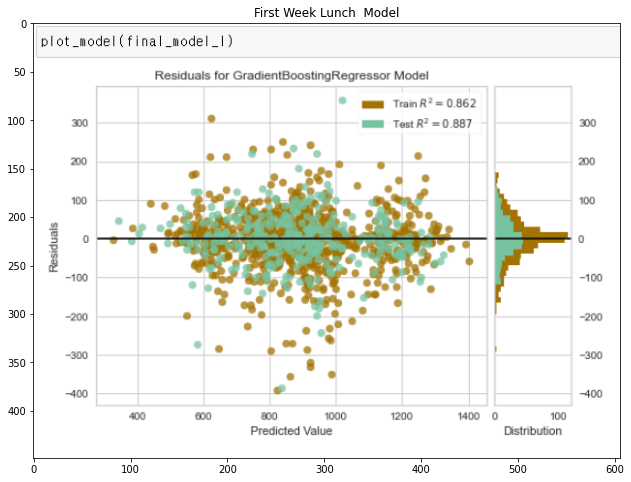

In [ ]:
img = cv2.imread('./Lunch_Another.png')
plt.figure(figsize=(15, 8))
plt.title("Another Week Lunch  Model")
plt.imshow(img)

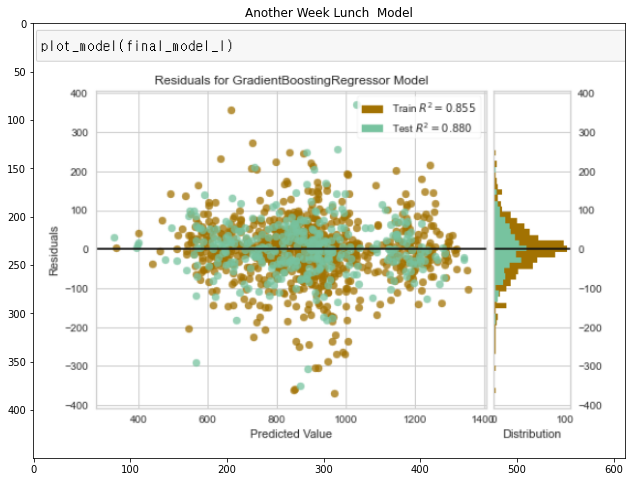

In [ ]:
img = cv2.imread('./Dinner_First.png')
plt.figure(figsize=(15, 8))
plt.title("First Week Dinner  Model")
plt.imshow(img)

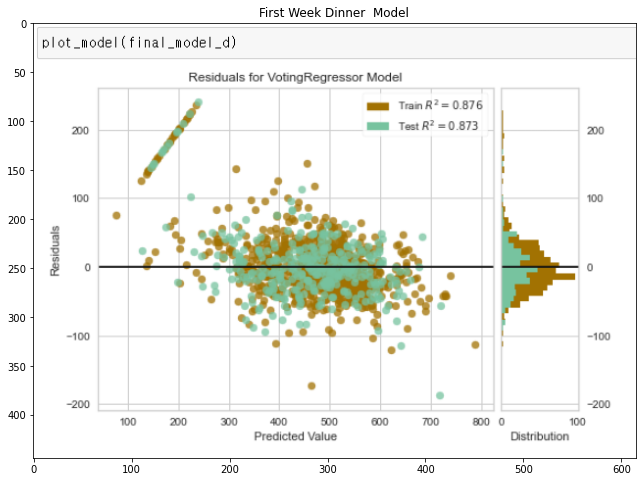

In [ ]:
img = cv2.imread("./Dinner_Another.png")
plt.figure(figsize=(15, 8))
plt.title("Another Week Dinner  Model")
plt.imshow(img)

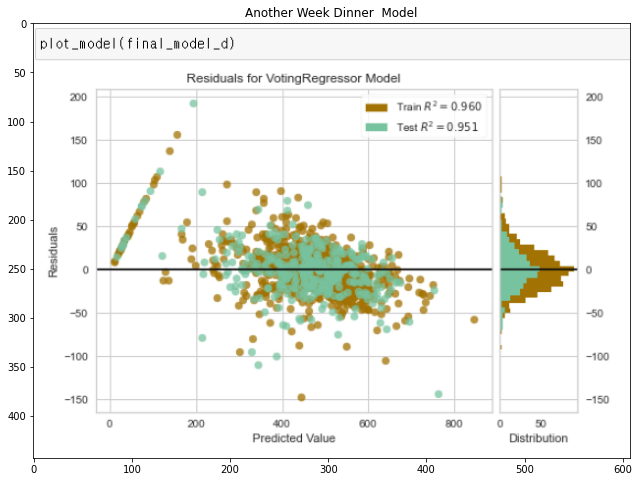

In [ ]:
submission_df["중식계"] = submission_df["중식계"] // 1 + 30

In [ ]:
submission_df["석식계"] = submission_df["석식계"] // 1 - 30

In [ ]:
submission_df.to_csv("./submission.csv", index=False)